In [57]:
import pandas as pd
import numpy as np
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from string import punctuation
from spellchecker import SpellChecker


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [3]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/qianzzz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qianzzz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Dataset

In [4]:
df = pd.read_csv('AI_Human.csv')

In [5]:
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [7]:
df.shape

(487235, 2)

In [8]:
df.describe()

,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
df.isnull().sum()

text         0
generated    0
dtype: int64

In [10]:
df['generated'].value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

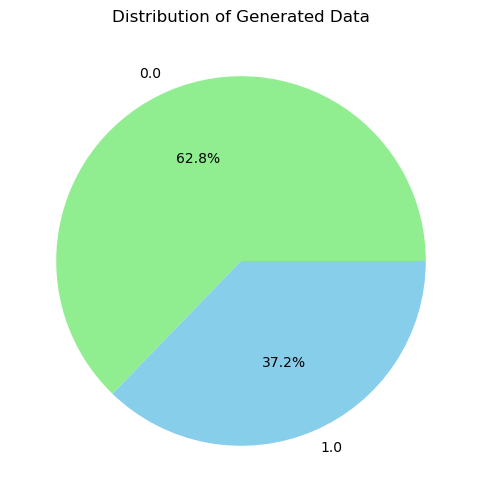

Total Texts: 487235
Human Written Texts: 305797
AI Generated Texts: 181438


In [11]:
generated_counts = df['generated'].value_counts()


plt.figure(figsize=(8, 6))
plt.pie(generated_counts, labels=generated_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'skyblue'])
plt.title('Distribution of Generated Data')
plt.show()

print('Total Texts:', df['generated'].count())
print('Human Written Texts:', (df['generated'] == 0.0).sum())
print('AI Generated Texts:', (df['generated'] == 1.0).sum())

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


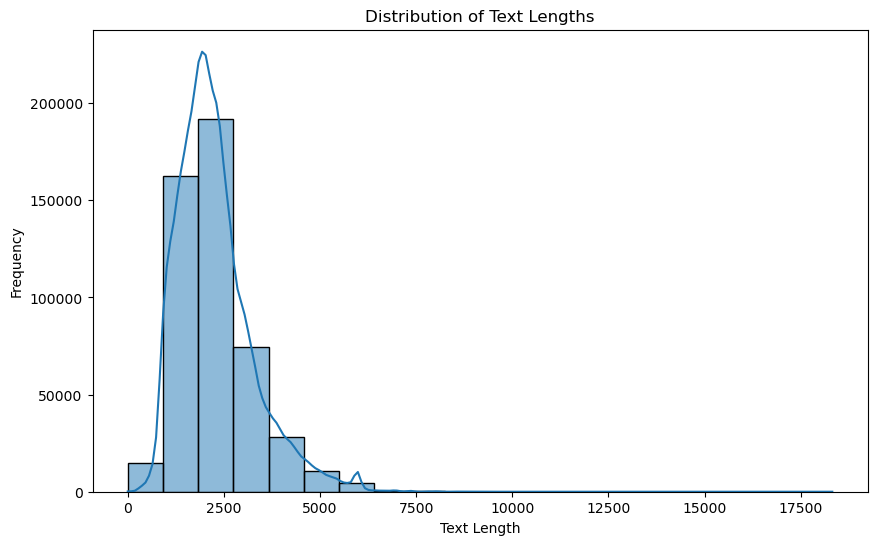

In [12]:
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=20, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

### Subset

#### To optimize the processing time due to the extensive size of the dataset, I created a smaller subset of the data for detailed analysis. This is helpful for more efficient and manageable data handling while maintaining the integrity of the analytical results.

In [13]:
df_human = df[df['generated'] == 0].copy()
df_AI = df[df['generated'] == 1].copy()

df_human= df_human.sample(3000)
df_AI= df_AI.sample(3000)

df_subset = pd.concat([df_human,df_AI], ignore_index=True)
df_subset

,text,generated,text_length
0,Schools Should use Facial Action Coding System...,0.0,3119
1,"Whether if it's a law in a country, the source...",0.0,3796
2,"Dear, state sector\n\nI do not agree oz how th...",0.0,2510
3,Professor Thomas Huang of the University of Il...,0.0,4089
4,I strongly agree with cell phones being banned...,0.0,2640
...,...,...,...
5995,"The author of ""The Challenge of Exploring Venu...",1.0,2405
5996,"The article ""The Challenge of Exploring Venus""...",1.0,3800
5997,"Dear Senator,\n\nI am writing to you as a conc...",1.0,2900
5998,Students should not be required to take classe...,1.0,956


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


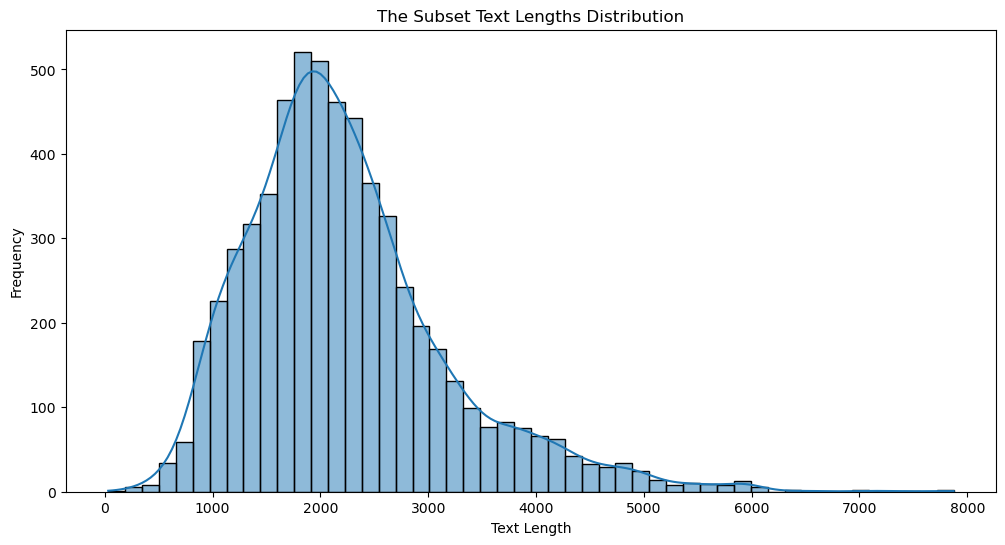

In [14]:
df_subset['text_length'] = df_subset['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_subset['text_length'], bins=50, kde=True)
plt.title("The Subset Text Lengths Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


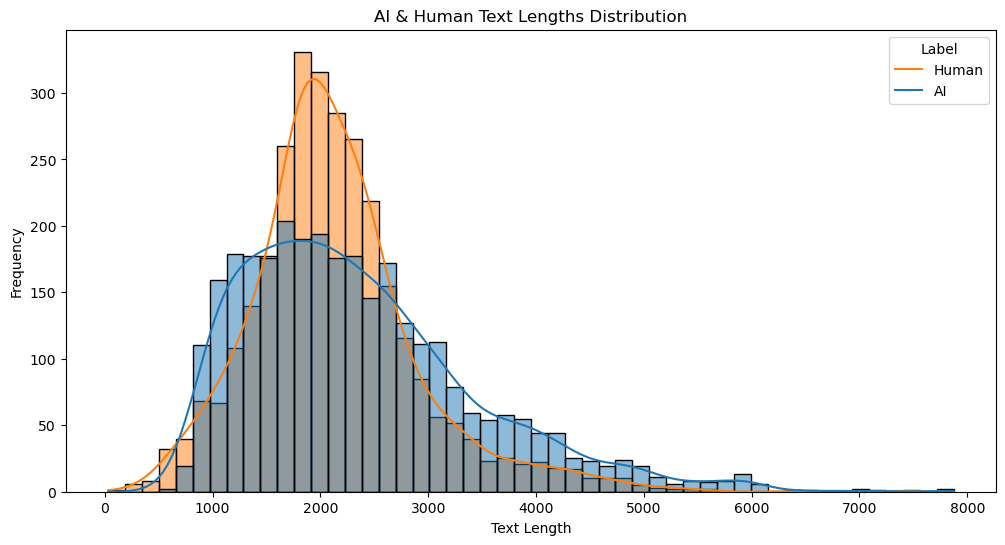

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(df_subset, x='text_length', hue='generated', bins=50, kde=True)
plt.title('AI & Human Text Lengths Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Human', 'AI'])
plt.show()

### Data Preprocessing

In [16]:
def text_preprocess(text):
    punc = list(punctuation)
    stop_words = stopwords.words('english')
    remove = punc + stop_words
    tokens = word_tokenize(text)
    lemma = WordNetLemmatizer()
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_tokens = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in remove]
    return " ".join(clean_tokens) 

In [17]:
df_subset['clean_text'] = df_subset['text'].apply(text_preprocess)

In [18]:
df_subset.sample(5)

,text,generated,text_length,clean_text
940,"Dear principle,\n\nI am against the new policy...",0.0,2216,dear principle i new policy b average order pl...
5818,I think that there is a need for stronger priv...,1.0,2259,i think need stronger privacy protection socia...
4772,Meditation and mindfulness practices have beco...,1.0,3455,meditation mindfulness practice become increas...
2349,I am Mackenzie Qazzleberry a scientist at\n\nN...,0.0,1142,i mackenzie qazzleberry scientist nasa seeing ...
527,"In the United States Ugh America, and all Over...",0.0,4095,in united state ugh america over world car use...


In [19]:
print('Original text:')
print(df_subset['text'][0])

Original text:
Schools Should use Facial Action Coding Systems

Try to imagine a world where people might be able to hide their feelings from others but not the computer. There has been a new software developed that has the ability to determine people's emotions called Facial Action Coding System. The software has even been able to determine exactly how much percent of each emotion is present in the Mona Lisa. As this software arises, there has been questions as to how schools could use this software to their advantage. With this system, schools could help students stay in tune in class, place students with teachers they learn well from, and force students to tell the truth.

The Facial Action Coding System should be used in schools because teachers would have the opportunity to change the way they are teaching when their students start to get bored. In so many cases students do not do well in school simply because their teacher might be too boring or confusing. If teachers had the abi

In [20]:
print('Cleaned text:')
print(df_subset['clean_text'][0])

Cleaned text:
school should use facial action coding system try imagine world people might able hide feeling others computer there new software developed ability determine people emotion called facial action coding system the software even able determine exactly much percent emotion present mona lisa a software arises question school could use software advantage with system school could help student stay tune class place student teacher learn well force student tell truth the facial action coding system used school teacher would opportunity change way teaching student start get bored in many case student well school simply teacher might boring confusing if teacher ability know student getting bored system good chance student would get better grade result with software classroom computer could recognize student becoming confused bored there would excuse teacher boring confusing student would tool become aware another key part student successful school teacher truly connect therefore sof

## Analysis

### 1. Sentiment Analysis

In [21]:
def calculate_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

In [22]:
df_subset['sentiment'] = df_subset['text'].apply(calculate_sentiment)

In [23]:
avg_sentiment = df_subset.groupby('generated')['sentiment'].mean()
print(avg_sentiment)

generated
0.0    0.596111
1.0    0.858287
Name: sentiment, dtype: float64


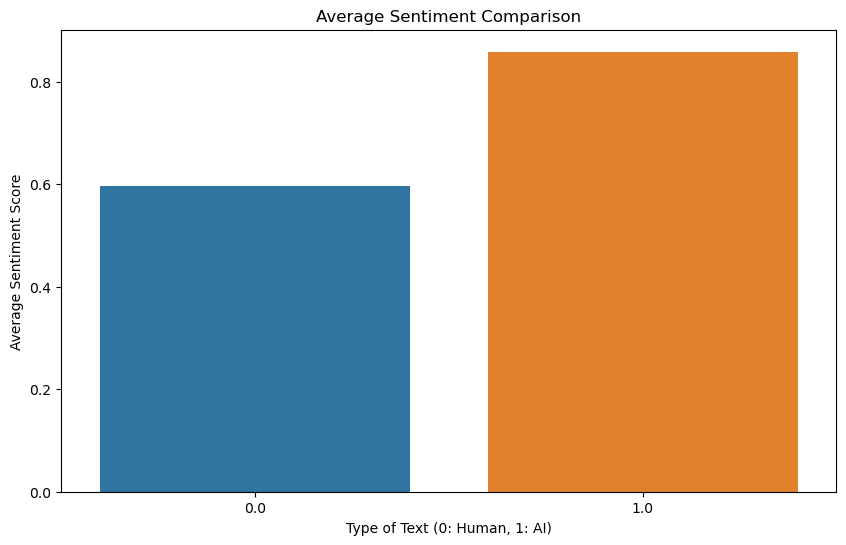

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_sentiment.index, y=avg_sentiment.values)
plt.title('Average Sentiment Comparison')
plt.xlabel('Type of Text (0: Human, 1: AI)')
plt.ylabel('Average Sentiment Score')
plt.show()


1. **Difference in Sentiment**: 
    - The most striking observation from this chart is the difference in average sentiment scores between the two types of texts. The AI-generated texts have a higher average sentiment score compared to the human-written texts. This suggests that AI-generated texts might be either using more positive language overall or are less likely to include negative sentiments compared to human texts.

2. **Implications for AI Text Generation**: 
    - If AI-generated texts consistently show higher positive sentiment, it could indicate that AI models may be biased towards generating more positive content. This could be due to the training data used or the algorithms' inherent design, which may prioritize more agreeable or less controversial content.

3. **Reader Perception and Engagement**: 
    - The difference in sentiment scores can also impact how readers perceive and engage with the content. Texts with higher positive sentiment might be perceived as more agreeable or pleasant, potentially affecting user engagement in contexts like marketing, customer service, or educational tools.

4. **Considerations for Use of AI in Writing**: 
    - For applications that require a balanced or nuanced emotional tone, the tendency of AI to produce text with higher sentiment scores might require adjustments or moderation. This is particularly relevant in journalism, creative writing, or other fields where emotional depth and variability are crucial.


### 2. Lexical Diversity Analysis

In [25]:
def calculate_ttr(text):
    tokens = word_tokenize(text)
    types = set(tokens)
    return len(types) / len(tokens) if tokens else 0


In [26]:
df_subset['ttr'] = df_subset['text'].apply(calculate_ttr)

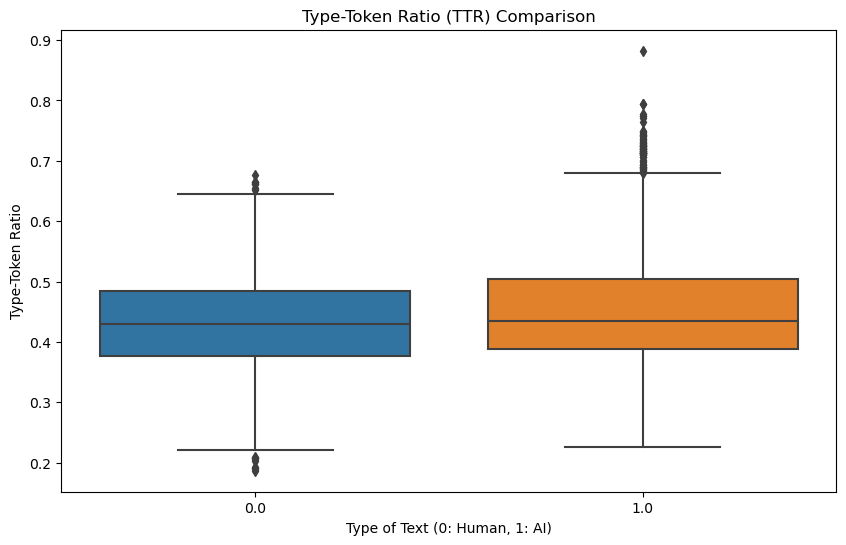

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='generated', y='ttr', data=df_subset)
plt.title('Type-Token Ratio (TTR) Comparison')
plt.xlabel('Type of Text (0: Human, 1: AI)')
plt.ylabel('Type-Token Ratio')
plt.show()

1. **Higher Lexical Diversity in AI-Generated Texts**: 
    - The orange box (label 1.0) has a slighterly higher median TTR than the blue box (label 0.0). This suggests that AI-generated texts, on average, use a wider variety of words compared to human-written texts in this dataset.

2. **Variability**: 
    - The AI-generated texts not only have a higher median TTR but also a wider interquartile range (IQR), suggesting greater variability in vocabulary diversity within these texts. The presence of many outliers above the upper whisker indicates that several AI-generated texts have exceptionally high TTR. 
    - The human-written texts show a more compact IQR, indicating less variability in vocabulary diversity. The distribution is tighter with fewer extreme outliers, which suggests a more consistent use of vocabulary among human writers.


3. **Implications**:
    - The higher and more variable TTR in AI-generated texts could imply that AI models may be programmed or trained to use a wider array of vocabulary to mimic diverse styles or to ensure that the generated text covers more varied vocabulary. This might be reflective of the AI’s training on large, diverse textual corpora.

    - The tighter distribution of TTR values in human-written texts suggests that humans tend to use a relatively consistent range of vocabulary when writing, possibly influenced by individual linguistic habits or limitations in contrast to AI's capability to draw on a vast dataset.


### 3. Generate WordClouds

In [28]:
def generate_wordcloud(data, title):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()

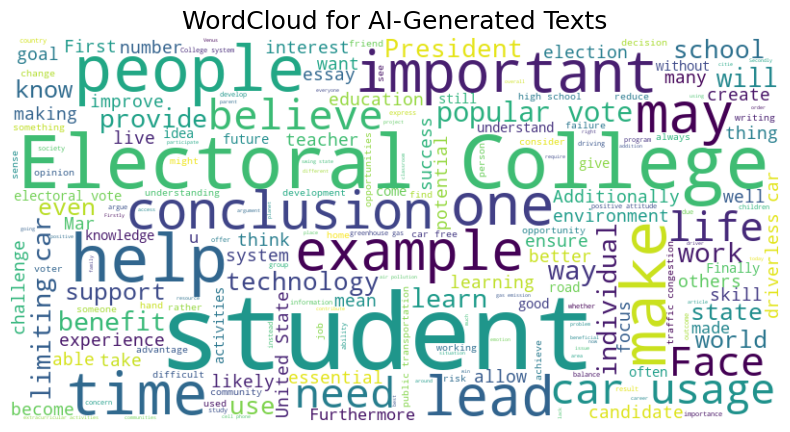

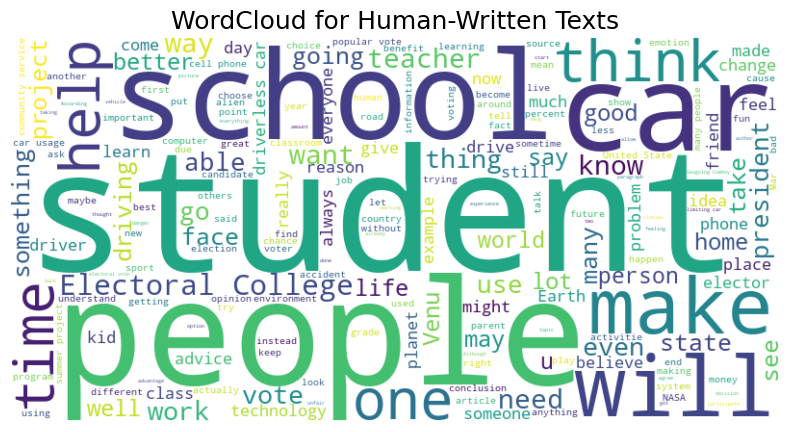

In [29]:
ai_texts = df_subset[df_subset['generated'] == 1]['text']
human_texts = df_subset[df_subset['generated'] == 0]['text']

generate_wordcloud(ai_texts, 'WordCloud for AI-Generated Texts')
generate_wordcloud(human_texts, 'WordCloud for Human-Written Texts')

1. **Common Themes**: 
    - Both AI-generated and human-written texts share common themes around elections, voting, and political systems. This overlap might indicate that both text types were possibly responding to similar prompts or themes.
    
2. **Tone and Formality**: 
    - AI-generated texts may lean towards a more formal and possibly repetitive use of key terms related to the given topics. In contrast, human texts might show greater variability in word use, reflecting natural language's fluidity and the integration of diverse contexts and personal expressions.
3. **Lexical Choice**: 
    - AI texts use certain terms repeatedly and prominently (e.g., "system," "president"), which might suggest either a limitation in vocabulary variability or a focus on maintaining topic relevance. Human texts seem to scatter focus across related terms more evenly, which could indicate a more nuanced understanding of the topic or a more conversational style.

### 4. Proportion of lemmatized words 

In [30]:
def lemma_proportion(text):
    doc = nlp(text)
    lemmas = {token.lemma_ for token in doc if token.is_alpha}  
    total_words = sum(1 for token in doc if token.is_alpha)
    return len(lemmas) / total_words if total_words > 0 else 0

In [31]:
df_subset['lemma_proportion'] = df_subset['text'].apply(lemma_proportion)

In [32]:
lemma_stats = df_subset.groupby('generated')['lemma_proportion'].mean()
print(lemma_stats)

generated
0.0    0.399832
1.0    0.444825
Name: lemma_proportion, dtype: float64


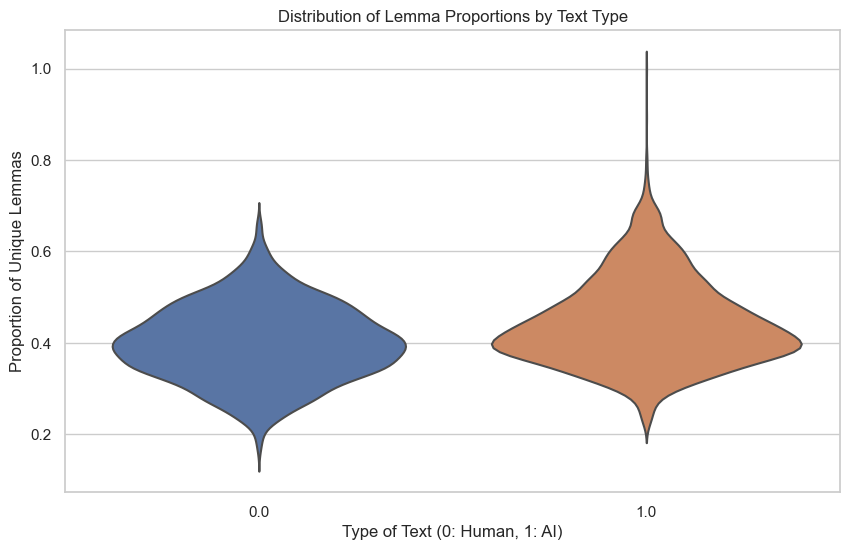

In [33]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='generated', y='lemma_proportion', data=df_subset, inner=None)
plt.title('Distribution of Lemma Proportions by Text Type')
plt.xlabel('Type of Text (0: Human, 1: AI)')
plt.ylabel('Proportion of Unique Lemmas')
plt.show()

1. **Distribution Shape and Spread**:
   - The human-written texts (blue) have a more extended lower spread, suggesting some human texts have a very low proportion of unique lemmas, possibly indicating repetitive use of a limited vocabulary or focused discussions on specific topics.
   - AI-generated texts (orange) show a broader distribution overall, implying a more varied lemma usage. The peak is sharper and higher than in human texts, suggesting a tendency towards a higher average lemma diversity.

2. **Central Tendency and Variability**:
   - AI-generated texts tend to have a higher median lemma proportion, indicative of a richer or more diverse vocabulary usage on average compared to human-written texts.
   - The distribution for AI texts is not only wider but also has a higher density near the median, highlighting consistency in using a diverse vocabulary.
3. **Implications**:
   - Vocabulary Diversity: AI appears to utilize a broader vocabulary base more consistently. This could be due to the nature of its training, where it may have been exposed to a wide variety of texts, enabling it to generate content with a higher diversity of lemmas.
    - Content Richness and Complexity: A higher lemma proportion generally suggests richer text content, which might be seen as more complex or engaging. AI's ability to maintain a diverse vocabulary could be advantageous in applications requiring content variety and richness.
    - Human Text Characteristics: The lower lemma proportions in some human texts could indicate specialized or niche content with focused vocabulary, or it could reflect the natural variability in human writing styles, which might not always prioritize lexical diversity.

### 5.Typo

In [34]:
spell = SpellChecker()

def count_typos(text):
    words = [word for word in text.split() if word.isalpha()]
    misspelled = spell.unknown(words)
    return len(misspelled)


In [35]:
df_subset['typos'] = df_subset['text'].apply(count_typos)

In [36]:
average_typos = df_subset.groupby('generated')['typos'].mean()
print(average_typos)

generated
0.0    4.240
1.0    2.674
Name: typos, dtype: float64


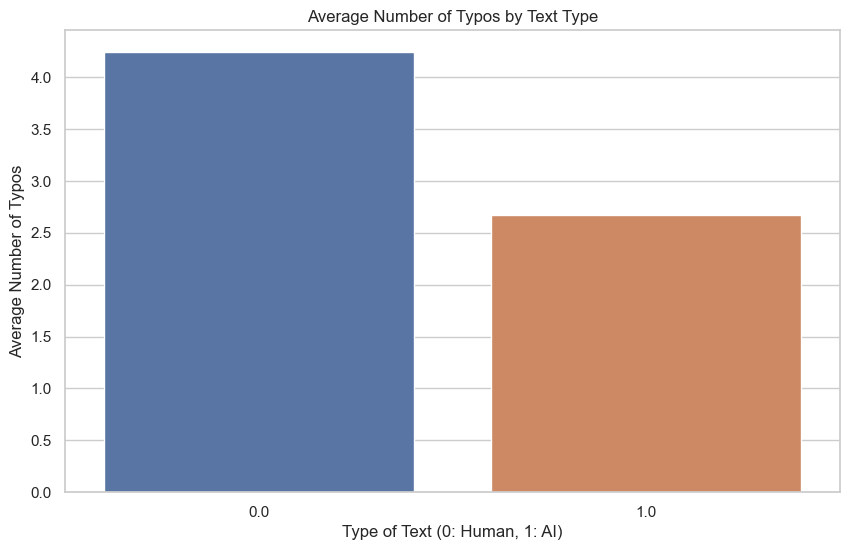

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x=average_typos.index, y=average_typos.values)
plt.title('Average Number of Typos by Text Type')
plt.xlabel('Type of Text (0: Human, 1: AI)')
plt.ylabel('Average Number of Typos')
plt.show()

1. **Higher Typo Frequency in Human-Written Texts:** 
    - The bar chart shows that human-written texts (blue bar) have a significantly higher average number of typos compared to AI-generated texts (orange bar). This suggests that human authors may be more prone to making typographical errors than the current AI systems used for generating texts.

2. **AI's Accuracy:** 
    - AI-generated texts demonstrate a lower average number of typos, which could be attributed to AI’s programming and its reliance on predefined language rules and dictionaries. This indicates a high level of precision in AI text generation, possibly reflecting robust proofing algorithms or better adherence to grammatical and spelling norms programmed into the AI.

In [38]:
df_subset

,text,generated,text_length,clean_text,sentiment,ttr,lemma_proportion,typos
0,Schools Should use Facial Action Coding System...,0.0,3119,school should use facial action coding system ...,0.9977,0.379074,0.323970,1
1,"Whether if it's a law in a country, the source...",0.0,3796,whether law country source pollution cause dea...,0.9346,0.453258,0.453795,11
2,"Dear, state sector\n\nI do not agree oz how th...",0.0,2510,dear state sector i agree oz election happezez...,0.9229,0.343454,0.304000,5
3,Professor Thomas Huang of the University of Il...,0.0,4089,professor thomas huang university illinois mad...,0.9972,0.385773,0.351351,9
4,I strongly agree with cell phones being banned...,0.0,2640,i strongly agree cell phone banned driving i h...,-0.9725,0.429435,0.392625,1
...,...,...,...,...,...,...,...,...
5995,"The author of ""The Challenge of Exploring Venu...",1.0,2405,the author the challenge exploring venus succe...,0.9975,0.464103,0.464387,1
5996,"The article ""The Challenge of Exploring Venus""...",1.0,3800,the article the challenge exploring venus pres...,0.9959,0.401015,0.410058,4
5997,"Dear Senator,\n\nI am writing to you as a conc...",1.0,2900,dear senator i writing concerned citizen great...,0.9951,0.488417,0.479821,6
5998,Students should not be required to take classe...,1.0,956,student required take class art music drama va...,0.9816,0.609195,0.632258,0


### 6. Modeling

In [74]:
X = df_subset[['text_length', 'sentiment', 'ttr', 'lemma_proportion', 'typos']] 
y = df_subset['generated'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.6491666666666667
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.52      0.60       613
         1.0       0.61      0.79      0.69       587

    accuracy                           0.65      1200
   macro avg       0.66      0.65      0.64      1200
weighted avg       0.66      0.65      0.64      1200



In [76]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [77]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.81
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       613
         1.0       0.83      0.78      0.80       587

    accuracy                           0.81      1200
   macro avg       0.81      0.81      0.81      1200
weighted avg       0.81      0.81      0.81      1200



            Feature  Importance
3  lemma_proportion    0.278847
2               ttr    0.218724
1         sentiment    0.216236
0       text_length    0.180819
4             typos    0.105375


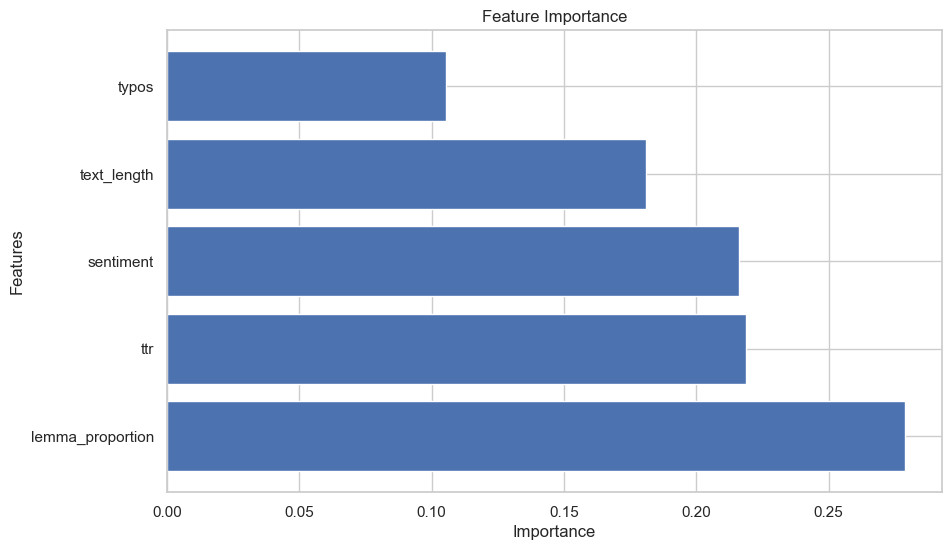

In [78]:
feature_importances = classifier.feature_importances_
features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

features.sort_values(by='Importance', ascending=False, inplace=True)
print(features)

plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

1. **Model Performance**:
   - The random forest classifier significantly outperformed the logistic regression model, with an accuracy of 81% compared to 64.9% achieved by logistic regression. This suggests that the ensemble method, which random forest employs, is more effective at handling the complexity and features of the dataset.

2. **Feature Importance**:
   - The analysis highlighted that 'lemma_proportion' (the proportion of unique lemmas) was the most important feature, followed by 'ttr' (Type-Token Ratio), 'sentiment', 'text_length', and 'typos'. This indicates that the richness and diversity of vocabulary, along with sentiment and structural attributes of the texts, play crucial roles in distinguishing between human-written and AI-generated texts.

3. **Typographical Errors**:
   - A notable observation was that human-written texts tend to have more typographical errors compared to AI-generated texts. This could reflect the precision of programmed AI in language rules and proofreading capabilities that reduce typos.

4. **Lexical Diversity**:
   - AI-generated texts exhibited higher lexical diversity and sentiment scores, potentially indicating a bias in AI systems towards generating more positive or diverse content. This could stem from the variety in training data or inherent model characteristics designed to produce engaging content.

5. **Implications for AI Text Generation**:
   - The findings suggest that while AI is capable of generating text with high lexical diversity and fewer typographical errors, it may also lean towards producing content with overly positive sentiment. This could affect the perception and authenticity of AI-generated text in sensitive applications such as journalism or literature where emotional depth and neutrality are important.


### TF-IDF

In [66]:
texts = df_subset['clean_text'] 
vectorizer = TfidfVectorizer(min_df=10,stop_words='english')
tfidf = vectorizer.fit_transform(texts)
tfidf = tfidf.toarray()

feature_names = vectorizer.get_feature_names_out()

In [68]:
tfidf_df = pd.DataFrame(tfidf, columns=feature_names)
print(tfidf_df.head())

    aa  aad  aan  abide   ability      able  aboard  abolish  abolished  \
0  0.0  0.0  0.0    0.0  0.066927  0.072354     0.0      0.0        0.0   
1  0.0  0.0  0.0    0.0  0.000000  0.000000     0.0      0.0        0.0   
2  0.0  0.0  0.0    0.0  0.000000  0.025780     0.0      0.0        0.0   
3  0.0  0.0  0.0    0.0  0.022653  0.000000     0.0      0.0        0.0   
4  0.0  0.0  0.0    0.0  0.028019  0.000000     0.0      0.0        0.0   

   abolishing  ...  younger  youth  youtube   yt  zaz  zero  zip   zn  \
0         0.0  ...      0.0    0.0      0.0  0.0  0.0   0.0  0.0  0.0   
1         0.0  ...      0.0    0.0      0.0  0.0  0.0   0.0  0.0  0.0   
2         0.0  ...      0.0    0.0      0.0  0.0  0.0   0.0  0.0  0.0   
3         0.0  ...      0.0    0.0      0.0  0.0  0.0   0.0  0.0  0.0   
4         0.0  ...      0.0    0.0      0.0  0.0  0.0   0.0  0.0  0.0   

         zo  zone  
0  0.000000   0.0  
1  0.000000   0.0  
2  0.203053   0.0  
3  0.000000   0.0  
4  0.00000

In [69]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df_subset['generated'], test_size=0.2, random_state=42)

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9658333333333333


**Conclusion for TF-IDF Analysis**:The implementation of TF-IDF (Term Frequency-Inverse Document Frequency) in this project effectively transformed the raw text data into a numerically weighted form, highlighting the importance of words within documents relative to their frequency across the entire corpus. This statistical approach allowed the machine learning models to better grasp the significance of less common but more informative words, improving their ability to differentiate between human-written and AI-generated texts.

### Topic Modeling

In [87]:
from gensim import corpora, models

texts = df_subset['clean_text'].apply(lambda x: [word for word in x.split() if word not in stopwords.words('english')])

dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_above=0.9, keep_n=500)
dictionary.compactify() 

corpus = [dictionary.doc2bow(text) for text in texts]



In [88]:
from gensim.models.ldamodel import LdaModel

lda_gensim = LdaModel(corpus=corpus,   # stream of document vectors or sparse matrix of shape
            id2word=dictionary,       # mapping from word IDs to words (for determining vocab size)
            num_topics=5,            # amount of topics
            random_state=42,         # seed to generate random state; useful for reproducibility
            passes=20,                 # amount of iterations/epochs 
            per_word_topics=False)    # computing most-likely topics for each word 

In [89]:
import pyLDAvis.gensim_models as gensimvis

panel = gensimvis.prepare(lda_gensim, corpus, dictionary, mds="tsne")

pyLDAvis.display(panel)

**Conclusion for Topic Modeling with LDA**: Topic modeling using Latent Dirichlet Allocation (LDA) provided profound insights into the thematic structure of the dataset, revealing distinct topics that characterize the corpus. By identifying these topics, the analysis could uncover underlying patterns and themes that may distinguish AI-generated texts from human-written ones.

## Conclusion

The project's analysis highlights that 'lemma_proportion' (proportion of unique words) is the most important feature, followed by 'ttr' (type-word ratio), 'sentiment', 'text_length' (text length), and 'typos' (error word). This suggests that lexical richness and diversity as well as the emotional and structural properties of the text play a key role in distinguishing between human-generated and AI-generated texts. But in terms of the accuracy of the model, we need to add more features to improve the accuracy of distinguishing between artificial and ai text. human-authored texts are more prone to typos than AI-generated texts, which may reflect the accuracy of programmed AI in terms of linguistic rules and proofreading capabilities, reducing the occurrence of typos.The AI-generated texts showed higher lexical diversity and sentiment scores, which may indicate that the AI system tends to produce more positive or diverse content when generating content. This may stem from the diversity of the training data or inherent model characteristics designed to produce engaging content. While AI has shown the ability to generate texts with high lexical diversity and fewer typos, it may also tend to generate overly positive emotional content. This may affect the perception and authenticity of AI-generated text in sensitive applications that require emotional depth and neutrality, such as journalism or literature.Finally, Through TF-IDF and LDA approaches to complex text analysis, this project not only enhances the understanding of the differences between AI and human texts, but also provides practical guidance for the application of AI technologies in areas such as education and content creation. The use of these techniques highlights the central role of data science in interpreting and enhancing AI applications, and lays the foundation for optimization and ethical considerations for future AI applications.